In [1]:
""" Import Package """
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import os
import random
from tqdm import tqdm
import wandb
import time
import copy
from sklearn.preprocessing import StandardScaler
from torch.optim.lr_scheduler import _LRScheduler
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import combinations

""" Global variables """
DATA = "./data"
TRAIN_DATA_PATH = f"{DATA}/training.csv"
TEST_DATA_PATH = f"{DATA}/test.csv"
OUTPUT_PREDICTION = f"{DATA}/predictions.csv"

First, we want to find the relationthips among the features in the dataset in order to help us decide how to utilize the combination of features.

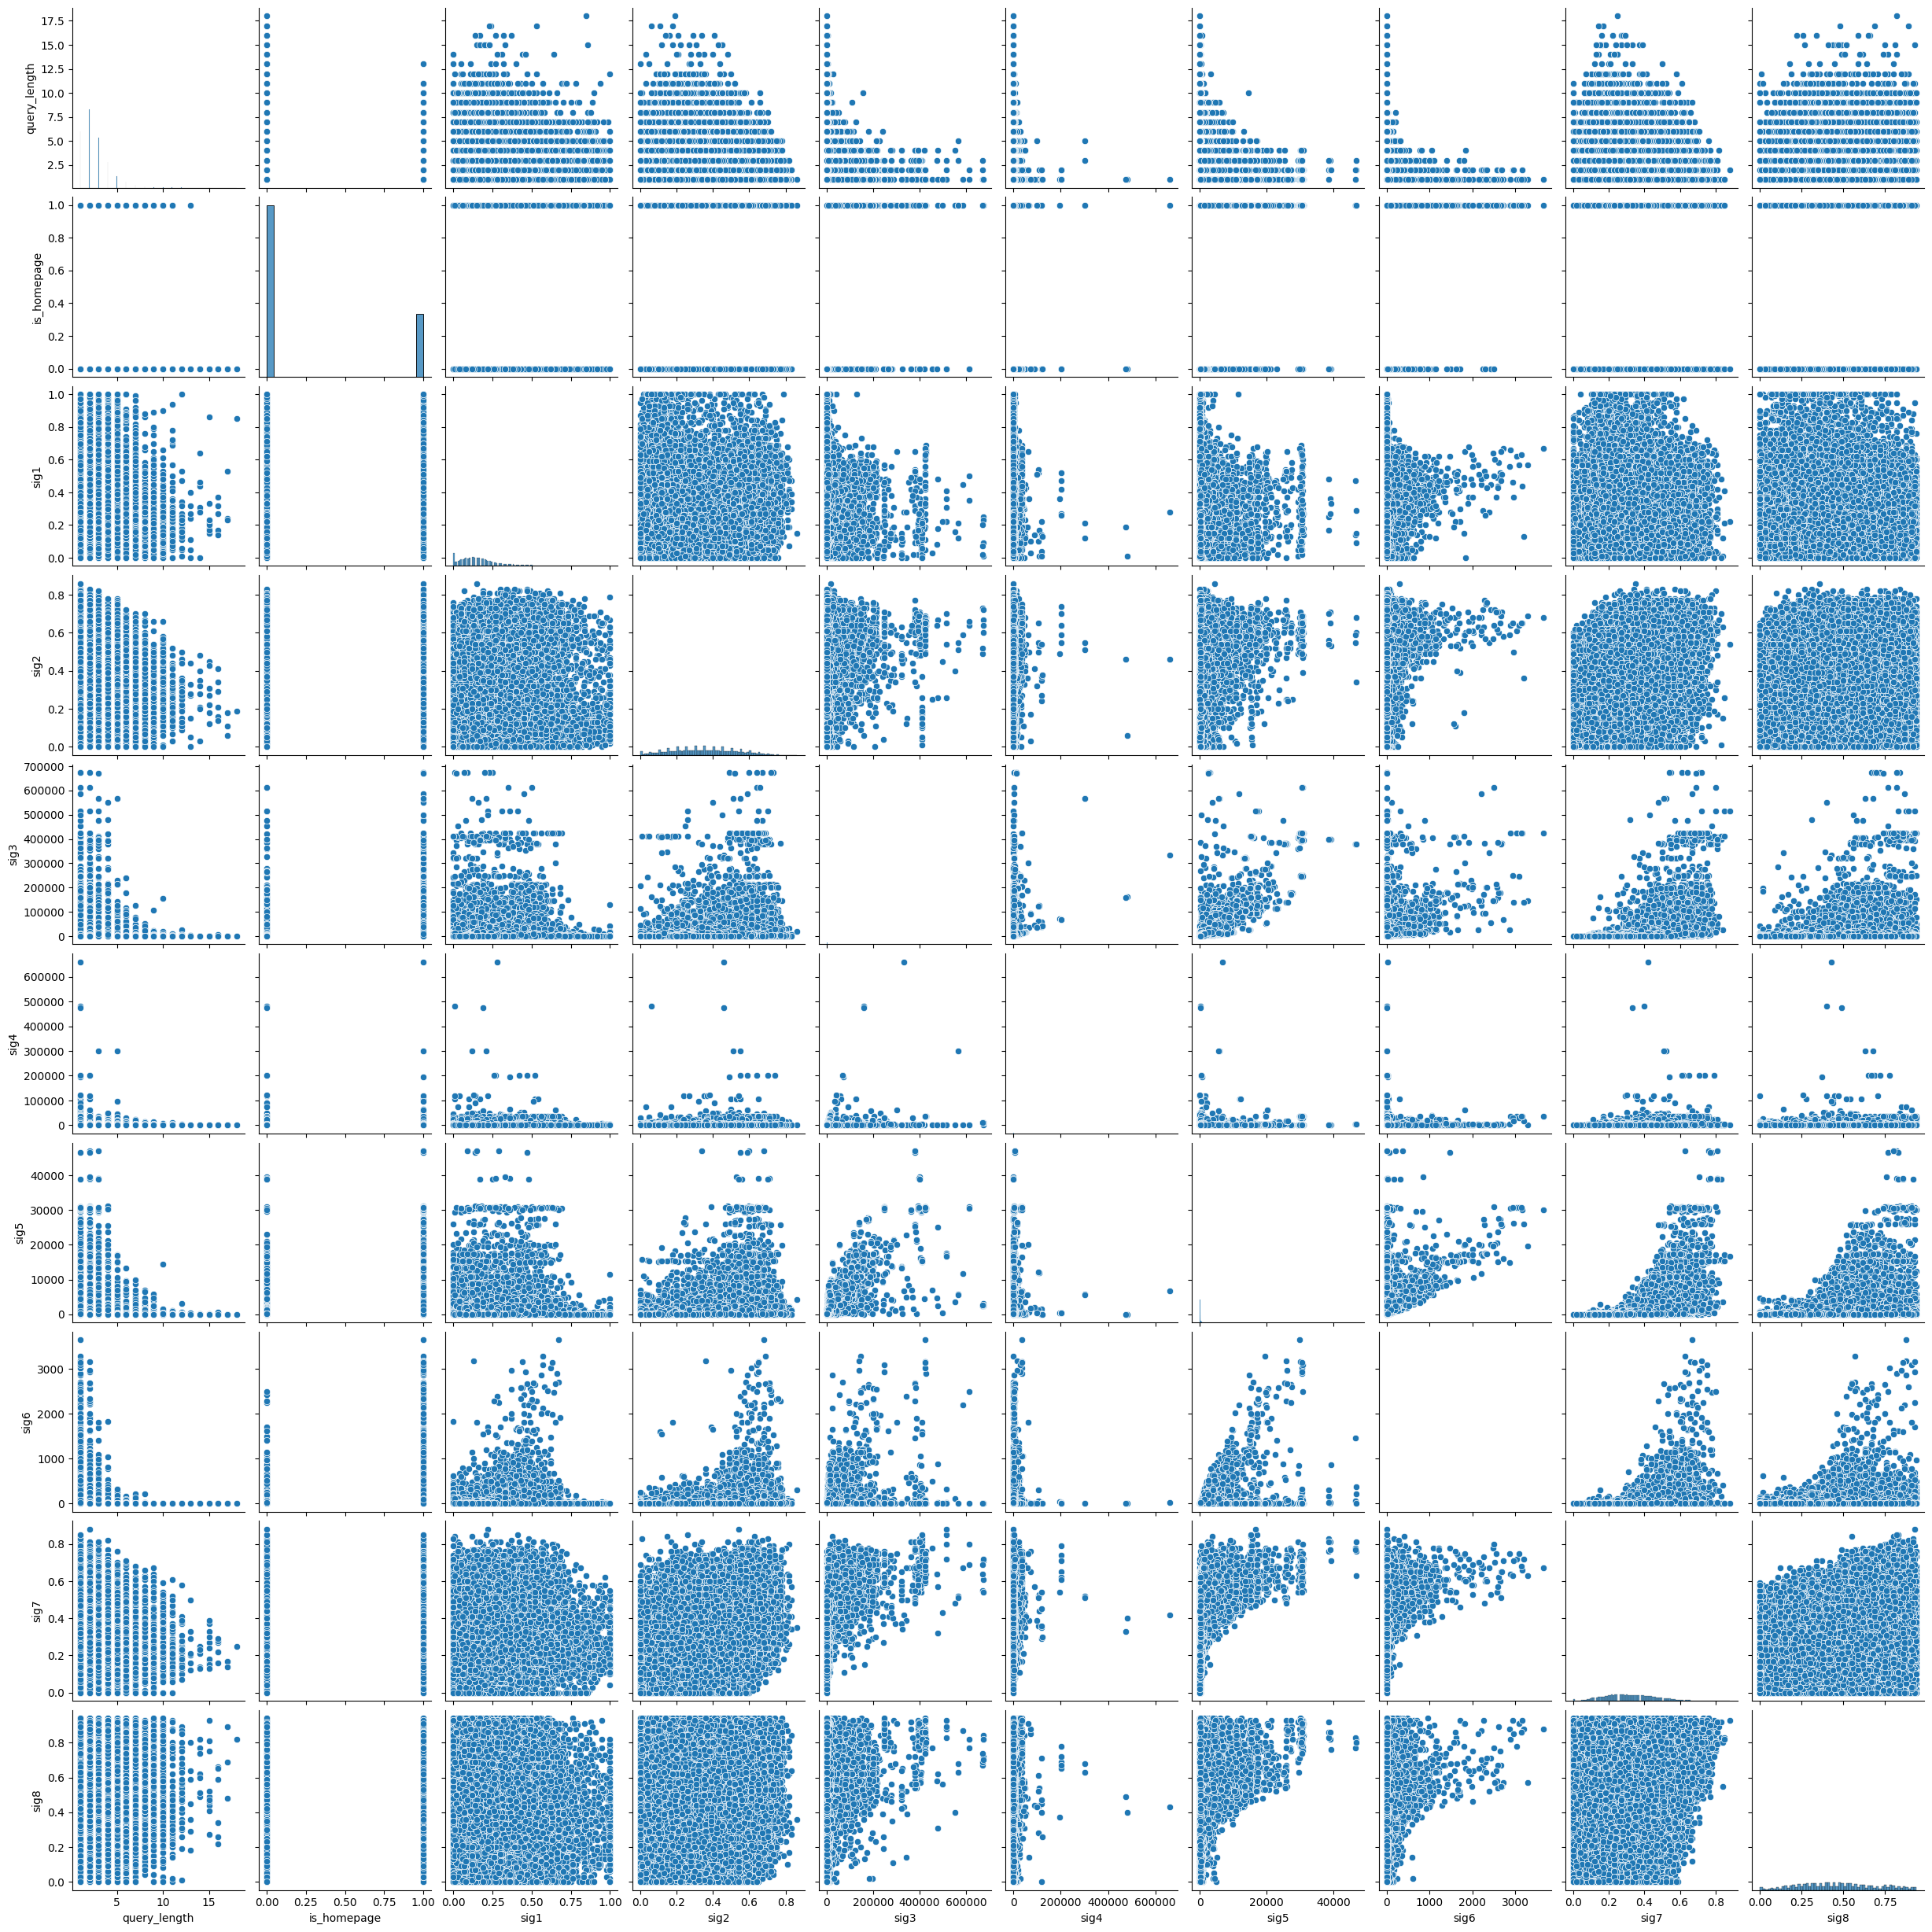

In [2]:
""" Visualize the relationships among features """
train_dataset = pd.read_csv(TRAIN_DATA_PATH)

features = train_dataset[['query_length', 'is_homepage', 'sig1', 'sig2', 
                          'sig3', 'sig4', 'sig5', 'sig6', 'sig7', 'sig8']]
sns.pairplot(features)
plt.show()

In [2]:
""" Load dataset """
class SearchEngineDataLoader(Dataset):
    """ Preprocess dataset """
    def __init__(self, file_path: str, train: bool, features: list, z_thresh=10.0):
        self.data = pd.read_csv(file_path)
        self.features = self.data[features].values
        if train:
            self.labels = self.data['relevance'].values
        else:
            self.labels = None
        
        pairwise_features = []
        '''for (f1, f2) in combinations([f for f in features if f.startswith('sig')], 2):
            self.data[f'{f1}_{f2}'] = self.data[f1] * self.data[f2]
            pairwise_features.append(f'{f1}_{f2}')'''
        
        # combine original and new features
        self.features_list = features + pairwise_features
        self.features = self.data[self.features_list].values

        # remove outliers
        if train == True:
            self.features, self.labels = self.remove_outliers(self.features, self.labels, z_thresh)

        # standardize data 
        scaler = StandardScaler()
        self.features = scaler.fit_transform(self.features)
    
    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        features = torch.tensor(self.features[idx], dtype=torch.float32)
        if self.labels is not None:
            label = torch.tensor(self.labels[idx], dtype=torch.float32).unsqueeze(0)
            return features, label
        else:
            return features
    
    def remove_outliers(self, features, labels, z_thresh):
        z_scores = np.abs((features - features.mean(axis=0)) / features.std(axis=0))
        mask = (z_scores < z_thresh).all(axis=1)
        features = features[mask]
        if labels is not None:
            labels = labels[mask]
        return features, labels
    
    def get_raw_feature(self, feature_name):
        """Method to access raw feature data"""
        return self.data[feature_name].values


def get_dataset(train_file_path: str,
                test_file_path: str,
                features: list):
    """ Create Dataset """
    train_dataset = SearchEngineDataLoader(train_file_path,
                                           train=True,
                                           features=features)
    test_dataset = SearchEngineDataLoader(test_file_path,
                                          train=False,
                                          features=features)
    return train_dataset, test_dataset


def get_dataloader(train_dataset: SearchEngineDataLoader,
                   test_dataset: SearchEngineDataLoader,
                   batch_size: int, 
                   val_proportion: float = 0,
                   pin_memory: bool = True,
                   shuffle: bool = True,
                   seed: int = 1) -> tuple[DataLoader, DataLoader, int, int]:
    """ Create Dataloader and return in_channels and num_classes """
    in_channels = train_dataset.features.shape[1]
    num_classes = 1  # Assuming binary classification

    # Split into train and validation sets if val_proportion > 0
    if val_proportion > 0:
        val_size = int(len(train_dataset) * val_proportion)
        train_size = len(train_dataset) - val_size
        generator = torch.Generator().manual_seed(seed)
        train_dataset, val_dataset = random_split(train_dataset, 
                                                  [train_size, val_size], 
                                                  generator=generator)
    else:
        train_dataset = train_dataset
        val_dataset = None
    
    # Create DataLoaders
    train_loader = DataLoader(train_dataset, 
                              batch_size=batch_size, 
                              shuffle=shuffle, 
                              num_workers=0, 
                              pin_memory=pin_memory)
    
    if val_dataset is not None:
        val_loader = DataLoader(val_dataset, 
                                batch_size=batch_size, 
                                shuffle=False, 
                                num_workers=0, 
                                pin_memory=pin_memory)
    else:
        val_loader = None
    
    test_loader = DataLoader(test_dataset, 
                             batch_size=batch_size, 
                             shuffle=False, 
                             num_workers=0, 
                             pin_memory=pin_memory)

    return train_loader, val_loader, test_loader, in_channels, num_classes


features = ['query_length', 'is_homepage', 'sig1', 'sig2', 
            'sig3', 'sig4', 'sig5', 'sig6', 'sig7', 'sig8']
batch_size = 1024

train_dataset, test_dataset = get_dataset(TRAIN_DATA_PATH,
                                          TEST_DATA_PATH,
                                          features)

train_loader, val_loader, test_loader, in_channels, num_class = get_dataloader(train_dataset=train_dataset,
                                                                               test_dataset=test_dataset,
                                                                               batch_size=batch_size,
                                                                               val_proportion=0.1,
                                                                               pin_memory=True,
                                                                               shuffle=True,
                                                                               seed=1,)
for feature, label in train_loader:
    print(feature.shape)
    print(label.shape)
    break
print(in_channels)
print(train_dataset.features.shape)

torch.Size([1024, 10])
torch.Size([1024, 1])
10
(79660, 10)


In [4]:
""" Modeling using logistic regression  """
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
# Initialize KFold
kf = KFold(n_splits=10, shuffle=True, random_state=1)

# Perform 10-fold cross-validation
cv_scores = cross_val_score(model, train_dataset.features, train_dataset.labels, cv=kf, scoring='accuracy')
print(f"10-fold Cross-Validation Accuracy: {np.mean(cv_scores)} ± {np.std(cv_scores)}")

# Train the model on the full training set
model.fit(train_dataset.features, train_dataset.labels)

# Predict on the test set
test_predictions = model.predict(test_dataset.features)

# Output predictions
print(f"Predictions on the test set: {test_predictions}")

10-fold Cross-Validation Accuracy: 0.6538287722821993 ± 0.004762735696289063
Predictions on the test set: [0 0 0 ... 1 0 1]


In [5]:
""" Modeling using RandomForest Classifier  """
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(
    n_estimators=300,
    max_depth=10,
    min_samples_split=5,
    random_state=42,
)
# Initialize KFold
kf = KFold(n_splits=10, shuffle=True, random_state=1)

# Perform 10-fold cross-validation
cv_scores = cross_val_score(model, train_dataset.features, train_dataset.labels, cv=kf, scoring='accuracy')
print(f"10-fold Cross-Validation Accuracy: {np.mean(cv_scores)} ± {np.std(cv_scores)}")

# Train the model on the full training set
model.fit(train_dataset.features, train_dataset.labels)

# Predict on the test set
test_predictions = model.predict(test_dataset.features)

# Output predictions
print(f"Predictions on the test set: {test_predictions}")

10-fold Cross-Validation Accuracy: 0.6650514687421542 ± 0.005517994222572411
Predictions on the test set: [0 1 1 ... 1 0 1]


In [6]:
""" Apply forward stepwise feature selection """
from sklearn.preprocessing import SplineTransformer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression

all_features = ['query_length', 'is_homepage', 'sig1', 'sig2', 'sig3', 'sig4', 'sig5', 'sig6', 'sig7', 'sig8']
optimal_features = []
optimal_cur_features = []
optimal_pre_features = []
best_acc = 0
for idx in range(len(all_features)):
    best_cur_acc = 0
    for new_feature in all_features:
        cur_features = optimal_pre_features[:]
        if new_feature not in optimal_pre_features:
            cur_features.append(new_feature)
        else:
            continue
        
        # Load dataset
        train_dataset, test_loader = get_dataset(TRAIN_DATA_PATH, 
                                                 TEST_DATA_PATH, 
                                                 features=cur_features)

        # Set model
        spline_transformer = SplineTransformer(n_knots=100, degree=3)
        model = LogisticRegression(random_state=1)
        pipeline = make_pipeline(spline_transformer, model)

        # Initialize KFold
        kf = KFold(n_splits=10, shuffle=True, random_state=1)

        # Perform 10-fold cross-validation
        cv_scores = cross_val_score(pipeline, train_dataset.features, train_dataset.labels, cv=kf, scoring='accuracy')
        
        if best_cur_acc <= np.mean(cv_scores):
            optimal_cur_features = cur_features
            best_cur_acc = np.mean(cv_scores)
    optimal_pre_features = optimal_cur_features
    if best_acc <= best_cur_acc:
        optimal_features = optimal_cur_features
        best_acc = best_cur_acc
print(f"Optimal features combination: {optimal_features} with best acc: {best_acc}")

c:\Users\A\anaconda3\envs\Pytorch\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Optimal features combination: ['sig2', 'sig6', 'query_length', 'sig1', 'is_homepage', 'sig8', 'sig3', 'sig7', 'sig4'] with best acc: 0.6616735666792122


So applying forward stepwise feature selection optimal ['sig2', 'query_length', 'sig6', 'sig1', 'is_homepage', 'sig4', 'sig8', 'sig7', 'sig3'] with 10 fold acc 0.6603948472635144 ± 0.006010424373950659.

In [3]:
""" Apply backward stepwise feature selection """
from sklearn.preprocessing import SplineTransformer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression

all_features = ['query_length', 'is_homepage', 'sig1', 'sig2', 'sig3', 'sig4', 'sig5', 'sig6', 'sig7', 'sig8']
optimal_features = []
optimal_cur_features = []
optimal_pre_features = ['query_length', 'is_homepage', 'sig1', 'sig2', 'sig3', 'sig4', 'sig5', 'sig6', 'sig7', 'sig8']
best_acc = 0
for idx in range(len(all_features) - 1):
    best_cur_acc = 0
    for new_feature in all_features:
        cur_features = optimal_pre_features[:]
        if new_feature in optimal_pre_features:
            cur_features.remove(new_feature)
        else:
            continue
        
        # Load dataset
        train_dataset, test_loader = get_dataset(TRAIN_DATA_PATH, 
                                                 TEST_DATA_PATH, 
                                                 features=cur_features)

        # Set model
        spline_transformer = SplineTransformer(n_knots=100, degree=3)
        model = LogisticRegression(random_state=1)
        pipeline = make_pipeline(spline_transformer, model)

        # Initialize KFold
        kf = KFold(n_splits=10, shuffle=True, random_state=1)

        # Perform 10-fold cross-validation
        cv_scores = cross_val_score(pipeline, train_dataset.features, train_dataset.labels, cv=kf, scoring='accuracy')
        
        if best_cur_acc <= np.mean(cv_scores):
            optimal_cur_features = cur_features
            best_cur_acc = np.mean(cv_scores)
    optimal_pre_features = optimal_cur_features
    if best_acc <= best_cur_acc:
        optimal_features = optimal_cur_features
        best_acc = best_cur_acc
print(f"Optimal features combination: {optimal_features} with best acc: {best_acc}")


c:\Users\A\anaconda3\envs\Pytorch\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Optimal features combination: ['query_length', 'is_homepage', 'sig1', 'sig2', 'sig4', 'sig5', 'sig6', 'sig7', 'sig8'] with best acc: 0.6619007447099097
